# Functional Autoencoder Clustering on Simulated Multivariate Time Series Datasets
---
This notebook performs functional clustering using an autoencoder model. It generates a synthetic multivariate time series dataset, preprocesses it into functional form, computes pairwise distances, constructs a similarity graph, trains a functional autoencoder (FAE), and evaluates the clustering performance using AMI and ARI metrics.

## 1. Import Required Libraries

In [1]:
import numpy as np
from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score
import time

# Import custom modules for functional autoencoder clustering
from FAEclust import (
    smoothing_features,
    bspline_basis,
    rescale,
    DatasetGenerator,
    TimeSeriesDistance,
    NearestNeighborsOpt,
    FunctionalAutoencoder,
)

## 2. Generate and Preprocess Synthetic Dataset
Generate dataset, standardised it for stability, and extract labels.

In [2]:
start = time.time()
# Parameters for data generation
name = 'pendulum'               # Dataset identifier
n_samples = 200                 # Number of time series samples
n_features = 2                  # Dimensionality of each series
n_steps = 100                   # Number of time points per series
n_clusters = 4                  # True number of clusters

# Generate data
print(f"Generating {name}: ({n_samples}, {n_features}, {n_steps}, {n_clusters} clusters)")
gen = DatasetGenerator(n_samples, n_features, n_steps, n_clusters)
X, y = getattr(gen, f"generate_{name}")()

# Standardise data for stability
X, y = rescale(X, y, name)

Generating pendulum: (200, 2, 100, 4 clusters)
pendulum: Shape of X = (200, 2, 100)


## 3. Compute Pairwise Distance Matrix
Use SRVF + Fisher-Rao metric to compute pairwise distances between multivariate time series dataset.

In [3]:
# Use elastic distance
n_samples, n_features, n_timesteps = X.shape
tsd = TimeSeriesDistance(X, metric='elastic', n_jobs=-1)
D = tsd.compute_distances()

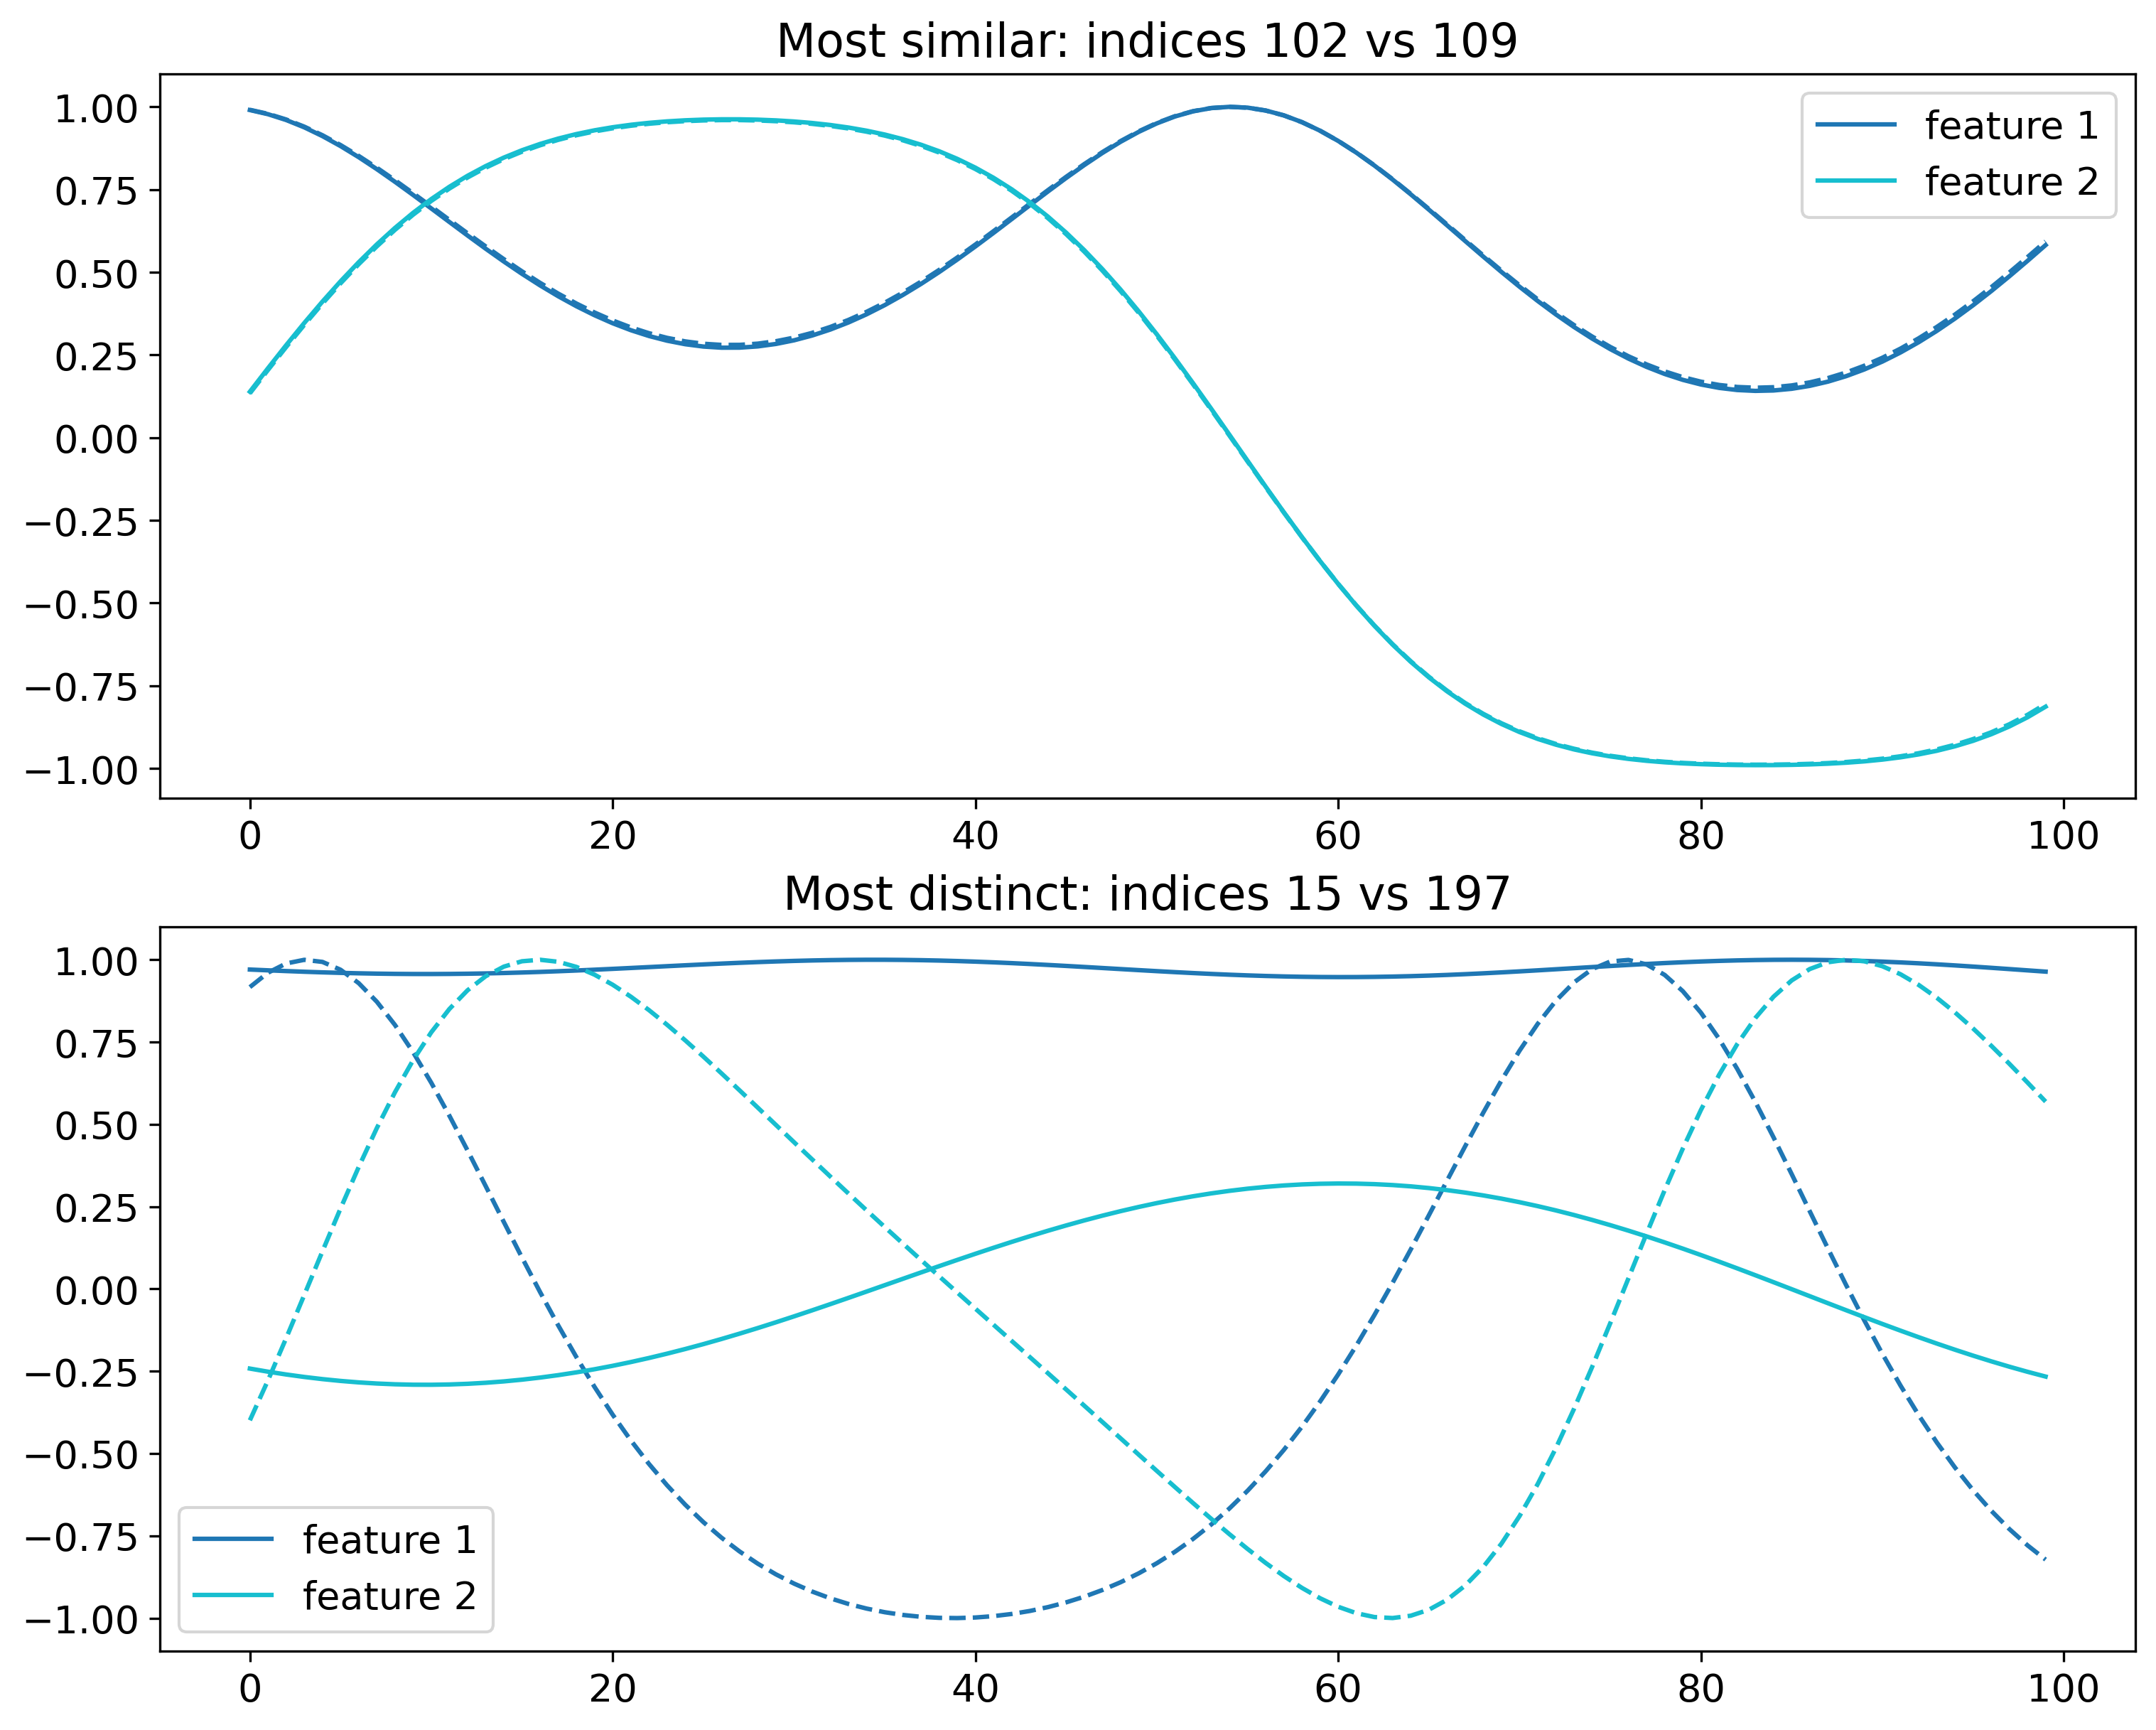

In [4]:
tsd.plot_extremes()    # plots the most similar and most dissimilar time series data

## 4. Build Nearest Neighbor Graph and Similarity Matrix

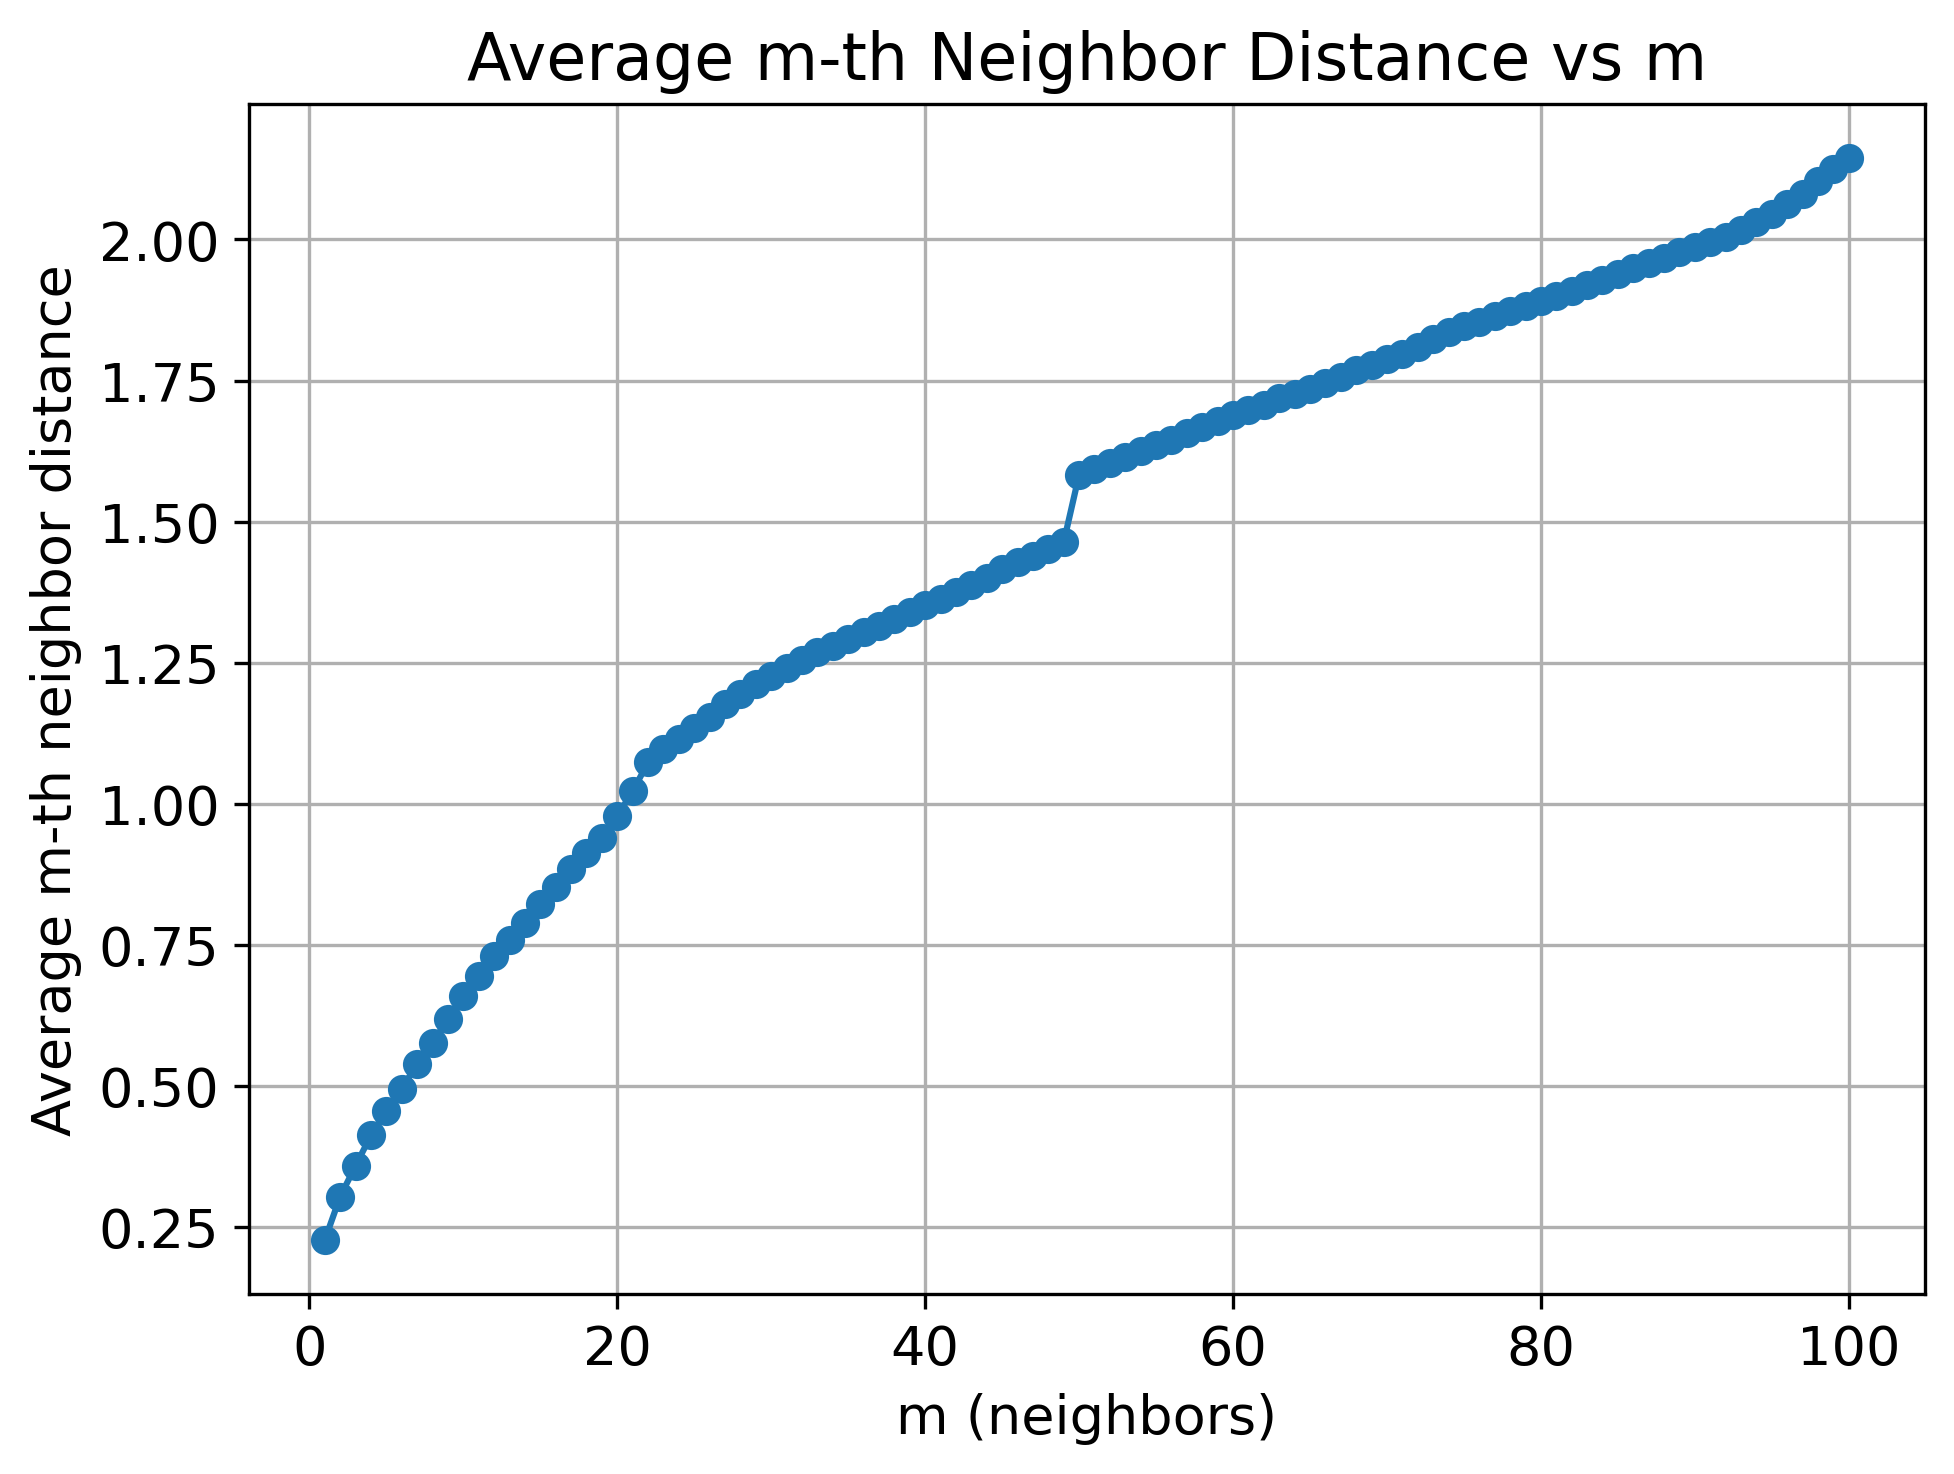

Optimal m (avg_distance): 50


In [5]:
# Estimate optimal number of nearest neighbors m
opt = NearestNeighborsOpt(D)
m = opt.estimate_optimal_m(method='avg_distance', max_m=n_samples-1)
# Alternatively, fix m based on inspection from the following graph
opt.plot_average_mth_distances(max_m = 100)     # plots the mth average distance
m = 50  # from average mth distance plot
print(f"Optimal m (avg_distance): {m}")

In [6]:
# Get neighbors and compute similarity matrix
neighbors_dict = opt.get_nearest_neighbors(opt_m=m)
sim_matrix = opt.compute_similarity(neighbors_dict)

## 5. Smooth and Extract Functional Features

In [7]:
# Parameters for smoothing
m_basis = 50                    # Number of smoothing basis functions
dis_p = 300                     # Discretisation points
t = np.linspace(0, 1, dis_p)    # Time grid

# Compute B-spline coefficients and curves
coeffs, curves, basis_smoothing = smoothing_features(
    X, m=m_basis, dis_p=dis_p, fit='bspline'
)

end = time.time()
print(f'{name}: pre-processing Time = {end - start:.2f} s')

pendulum: pre-processing Time = 42.21 s


## 6. Train Functional Autoencoder (FAE)
Define the network architecture, regularisation, and training parameters, then train the model.

In [8]:
# Model architecture parameters
p = n_features                      # Input dimensions
layers = [16, 8, 2, 8, 16, 16, 16]  # Encoder/decoder sizes
l_basis = 50                        # Basis funcs for model weights
basis_input = bspline_basis(num_basis=l_basis)

# Regularisation and training settings
lambda_e, lambda_d, lambda_c = 0.5, 0.05, 0.5
epochs = 100
learning_rate = 1e-3
batch_size = 16

# Instantiate model with similarity constraints
FAE_model = FunctionalAutoencoder(
    p, layers, l=l_basis, m=m_basis,
    basis_smoothing=basis_smoothing,
    basis_input=basis_input,
    lambda_e=lambda_e, lambda_d=lambda_d, lambda_c=lambda_c,
    t=t, sim_matrix=sim_matrix
)

# Show architecture and train
FAE_model.model_summary()
start = time.time()
FAE_model.train(
    coeffs, epochs=epochs, learning_rate=learning_rate,
    batch_size=batch_size, neighbors_dict=neighbors_dict,
    sim_matrix=sim_matrix
)
end = time.time()
print(f'{name}: network training Time = {end - start:.2f} s')

Functional Autoencoder:
Layer (type)              Shape                          Param #   
wfn                       (16, 2, 50)                    1600      
bfn                       (16,)                          16        
W_enc_1                   (16, 8)                        128       
b_enc_1                   (8,)                           8         
W_enc_2                   (8, 2)                         16        
b_enc_2                   (2,)                           2         
W_dec_2                   (2, 8)                         16        
b_dec_2                   (8,)                           8         
W_dec_1                   (8, 16)                        128       
b_dec_1                   (16,)                          16        
Wfn1                      (16, 16, 50)                   12800     
Bfn1                      (16, 50)                       800       
Wfn2                      (16, 16, 50)                   12800     
Bfn2                    

## 7. Evaluate Clustering Performance

In [9]:
# Predict and evaluate clustering
S, labels = FAE_model.predict(coeffs, batch_size=batch_size)
ami = adjusted_mutual_info_score(y, labels)
ari = adjusted_rand_score(y, labels)

# Display metrics
print(f'AMI score: {ami:.4f}')
print(f'ARI score: {ari:.4f}')
print(f'Clusters predicted: {len(np.unique(labels))}')

AMI score: 0.9481
ARI score: 0.9293
Clusters predicted: 5


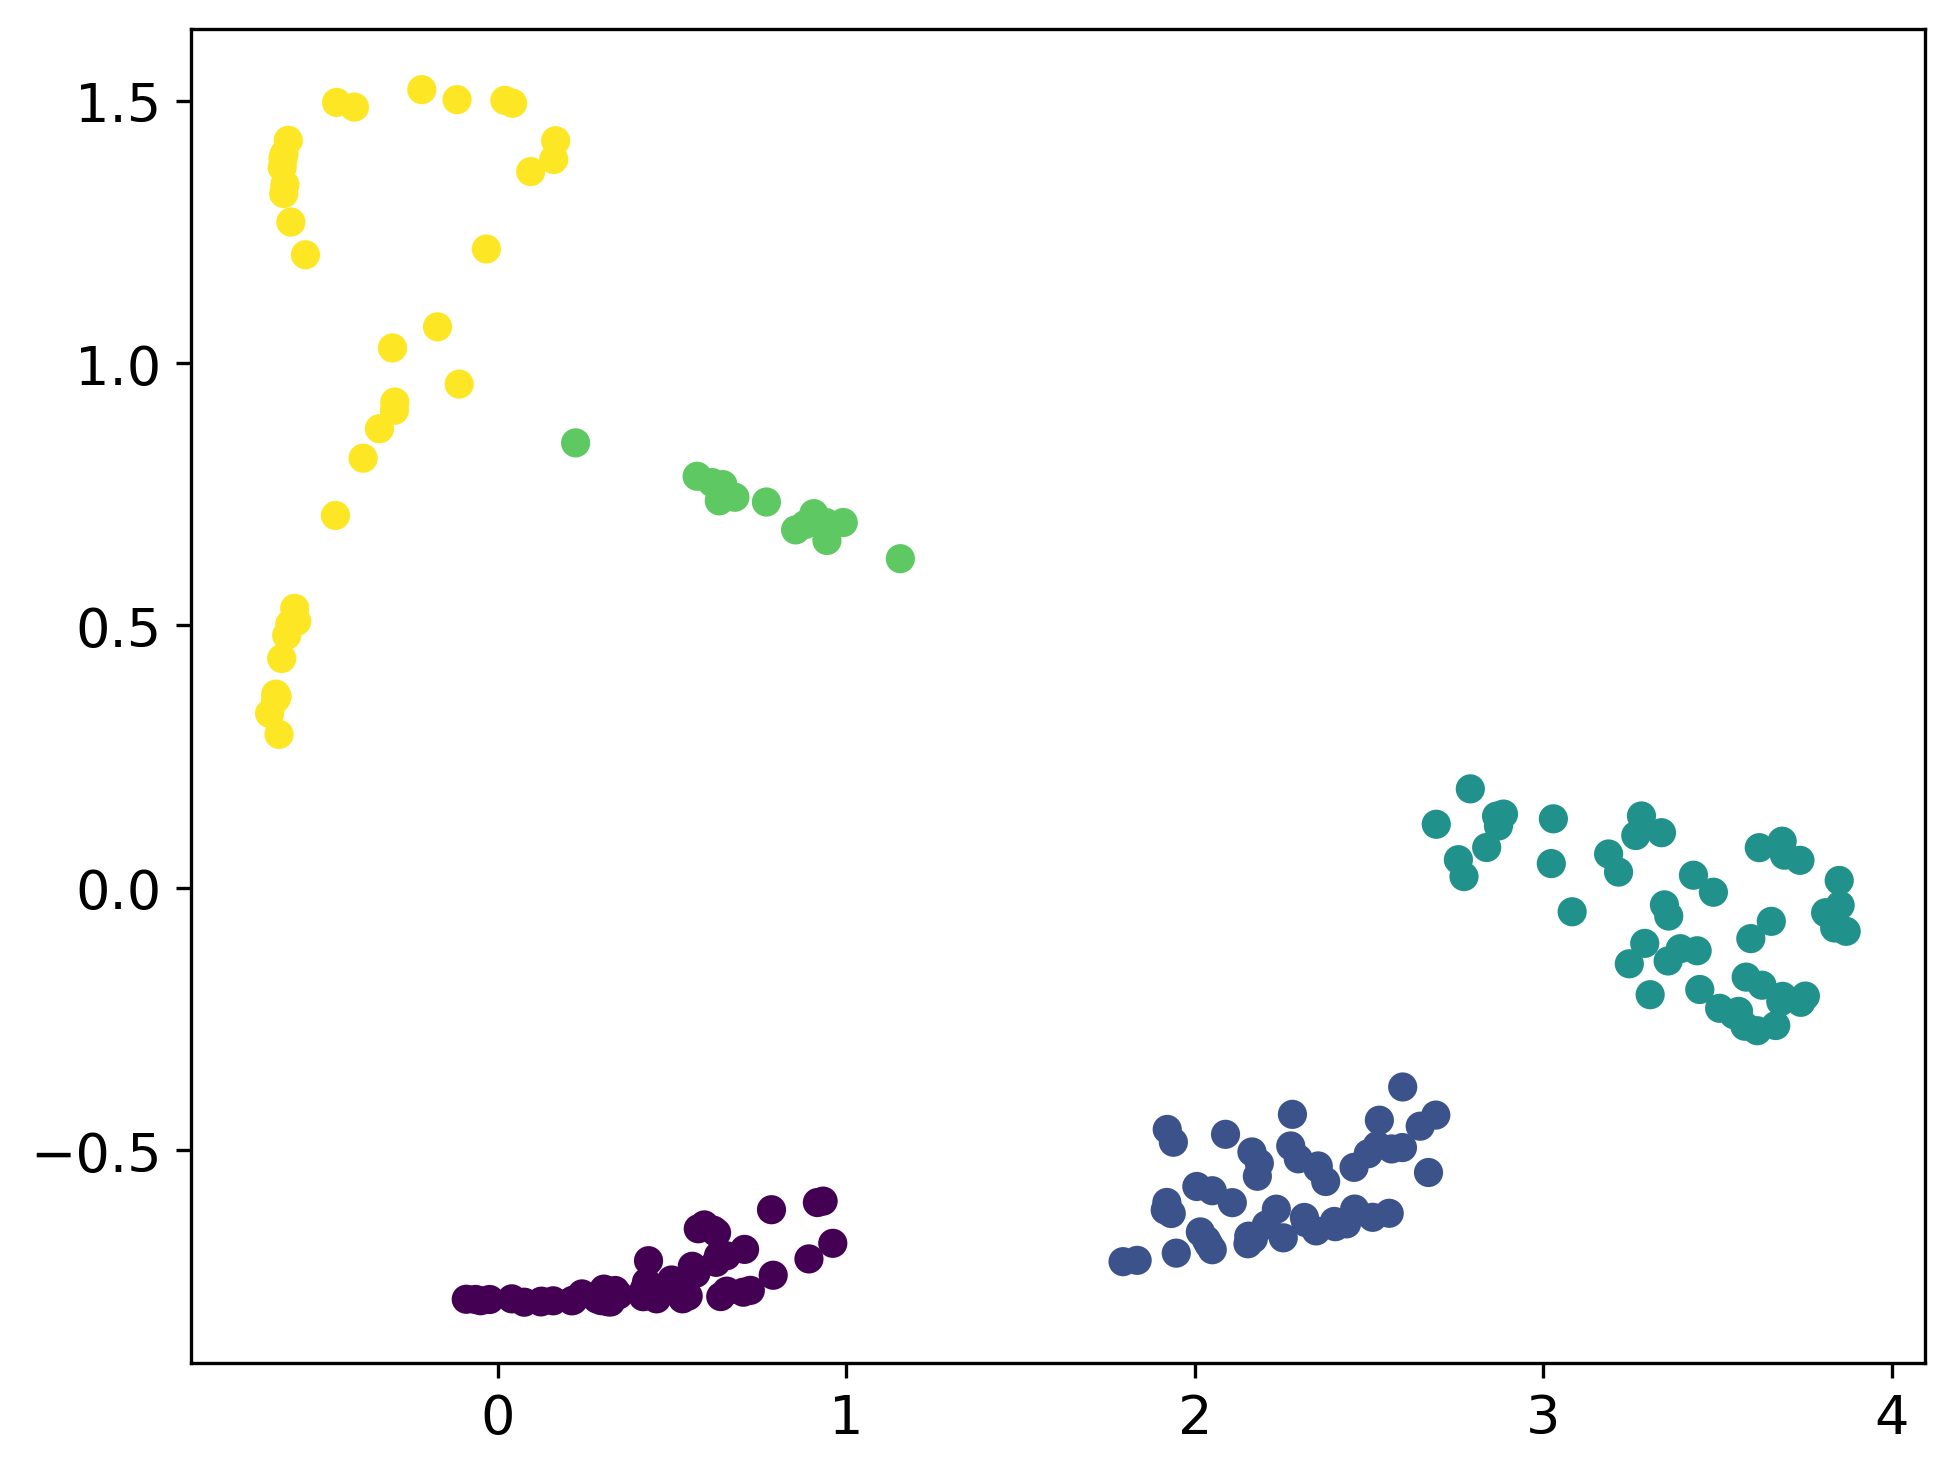

In [10]:
# Visualise the latent representations, since latent space is in 2D
import matplotlib.pyplot as plt
plt.scatter(S[:,0], S[:,1], c=labels)